In [2]:
import os
import numpy as np
import scipy.io as sio
import torch
import random
import mne
import re
from torch.utils.data import Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from braindecode.preprocessing import exponential_moving_standardize
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp
from braindecode.datasets.bbci import BBCIDataset

python(5168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [15]:
class BCIDataset(Dataset):
    def __init__(self, root_dir, n_participants=15, selected_participants=None):
        self.data = []
        self.labels = []
        
        n_classes = 4
        trials_per_class = 12
        
        participants = [p for p in os.listdir(root_dir) 
                      if os.path.isdir(os.path.join(root_dir, p)) and re.match(r'^S\d{3}$', p)]
        
        if selected_participants:
            participants = [p for p in participants if p in selected_participants]
        else:
            if len(participants) > n_participants:
                participants = np.random.choice(participants, n_participants, replace=False)
                
        successful_participants = []
        for participant in participants:
            participant_path = os.path.join(root_dir, participant)
            edf_files = [f for f in os.listdir(participant_path) if f.endswith('.edf')]

            class_trials = [[] for _ in range(n_classes)]
            
            for file in edf_files:
                file_path = os.path.join(participant_path, file)

                match = re.search(r'R(\d{2})', file)
                if not match:
                    continue
                run_number = int(match.group(1))

                is_fists_feet_run = run_number in [5, 6, 9, 10, 13, 14]
                is_left_right_run = run_number in [3, 4, 7, 8, 11, 12]
                
                if not (is_fists_feet_run or is_left_right_run):
                    continue

                try:
                    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    continue

                event_id = {'T0': 0, 'T1': 1, 'T2': 2}
                try:
                    with mne.use_log_level('ERROR'):
                        events, _ = mne.events_from_annotations(raw, event_id=event_id)
                except Exception as e:
                    print(f"Error parsing annotations for {file_path}: {e}")
                    continue

                if len(events) == 0:
                    print(f"Skipping {file_path}: no valid events found")
                    continue

                raw.pick('eeg')
                raw.filter(1., 40., fir_design='firwin', verbose=False)

                current_sfreq = raw.info['sfreq']
                target_sfreq = 160
                if current_sfreq != target_sfreq:
                    raw.resample(target_sfreq, npad="auto")

                duration = int(target_sfreq * 4)

                events = sorted(events, key=lambda x: x[0])

                for event_idx, event in enumerate(events):
                    if event_idx < 2:
                        continue
                        
                    event_type = event[2]

                    if event_type == 0:
                        continue
                    
                    onset = event[0]
                    if onset + duration > len(raw.times):
                        continue

                    trial_data = raw.get_data(start=onset, stop=onset + duration)
                    if trial_data.shape[1] != duration:
                        continue

                    if is_left_right_run:
                        if event_type == 1:
                            class_idx = 0
                        elif event_type == 2:
                            class_idx = 1
                        else:
                            continue
                    elif is_fists_feet_run:
                        if event_type == 1:
                            class_idx = 2
                        elif event_type == 2:
                            class_idx = 3
                        else:
                            continue
                    
                    class_trials[class_idx].append(trial_data)
            
            class_counts = [len(trials) for trials in class_trials]
            if any(count < trials_per_class for count in class_counts):
                print(f"Skipping {participant}: insufficient trials in at least one class")
                print(f"  Class counts: {class_counts}")
                continue

            participant_data = []
            participant_labels = []
            
            for class_idx, trials in enumerate(class_trials):
                selected_indices = np.random.choice(len(trials), trials_per_class, replace=False)
                selected_trials = [trials[i] for i in selected_indices]
                
                participant_data.extend(selected_trials)
                participant_labels.extend([class_idx] * trials_per_class)
            
            participant_data = np.array(participant_data)
            participant_labels = np.array(participant_labels)
            
            self.data.append(participant_data)
            self.labels.append(participant_labels)
            successful_participants.append(participant)

        if len(successful_participants) < n_participants:
            print(f"Warning: Only found {len(successful_participants)} valid participants instead of the requested {n_participants}")

        if self.data:
            self.data = np.concatenate(self.data, axis=0)
            self.labels = np.concatenate(self.labels, axis=0)
        else:
            self.data = np.array([])
            self.labels = np.array([])

        if self.data.size > 0:
            print(f"Final dataset size: {self.data.shape[0]} trials, each with shape {self.data.shape[1:]} (channels × timepoints)")
            print(f"Label distribution: {np.bincount(self.labels)}")
        else:
            print("Final dataset is empty.")
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [16]:
# preprocess data
def preprocess_data(X):
    X = X * 1e6
    X = exponential_moving_standardize(X, factor_new = 1e-3, init_block_size = 1000)
    return X

In [27]:
# for optimized hyperparameters
class EEGExperiment:
    def __init__(self, data_dir, epochs=15):
        self.data_dir = data_dir
        self.epochs = epochs

    def _load_data(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)

        dataset = BCIDataset(self.data_dir)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])
        return train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

    def _train_model(self, X_train, y_train, X_val, y_val, lr, batch_size):
        n_classes = 4
        n_chans, input_time_length = X_train.shape[1], X_train.shape[2]

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length='auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            optimizer__lr=lr,
            train_split=predefined_split(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())),
            batch_size=batch_size,
            callbacks=[
                'accuracy',
                ('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max=self.epochs - 1))
            ],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            classes=list(range(n_classes))
        )

        clf.fit(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), y=None, epochs=self.epochs)
        return clf

    def run(self, learning_rates, batch_sizes, repeats=10):
        best_acc = 0
        best_config = None

        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nTesting config: lr = {lr}, batch_size = {batch_size}")
                X_train, X_val, y_train, y_val = self._load_data(seed = 2025)
                clf = self._train_model(X_train, y_train, X_val, y_val, lr, batch_size)
                acc = float(clf.history[-1, 'valid_accuracy'])

                print(f" → Accuracy: {acc:.4f}")
                if acc > best_acc:
                    best_acc = acc
                    best_config = {'lr': lr, 'batch_size': batch_size}

        print(f"\nBest config: {best_config}, Accuracy: {best_acc:.4f}")

        all_histories = []
        val_accuracies = []

        for i in range(repeats):
            print(f"Repeat {i+1}/{repeats}")
            X_train, X_val, y_train, y_val = self._load_data(seed = 2025 + i)
            clf = self._train_model(X_train, y_train, X_val, y_val,
                                    best_config['lr'], best_config['batch_size'])
            acc = float(clf.history[-1, 'valid_accuracy'])
            val_accuracies.append(acc)
            all_histories.append(clf.history)

        mean_acc = np.mean(val_accuracies)
        std_acc = np.std(val_accuracies)
        print(f"\nFinal result — Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

        return {
            'best_model': clf,
            'best_config': best_config,
            'all_accuracies': val_accuracies,
            'all_histories': all_histories,
            'mean_acc': mean_acc,
            'std_acc': std_acc
        }

In [28]:
data_dir = '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/BCI2000'

experiment = EEGExperiment(data_dir=data_dir, epochs=15)
results = experiment.run(
    learning_rates=[0.001, 0.0005],
    batch_sizes=[32, 64],
    repeats=10
)

print("Best hyperparameters:", results['best_config'])
print("Validation accuracies:", results['all_accuracies'])


Testing config: lr = 0.001, batch_size = 32
Final dataset size: 720 trials, each with shape (64, 640) (channels × timepoints)
Label distribution: [180 180 180 180]


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3542        1.8602       0.2153            0.2153        1.5802  0.0010  2.5857
      2            0.4774        1.5994       0.2222            0.2222        1.5095  0.0010  2.1665
      3            0.5417        1.4740       0.2917            0.2917        1.4626  0.0010  2.1633
      4            0.5764        1.4116       0.2153            0.2153        1.5001  0.0009  2.2048
      5            0.6389        1.2322       0.3056            0.3056        1.4708  0.0008  2.1614
      6            0.6458        1.2193       0.2847            0.2847        1.4780  0.0007  2.1702
      7            0.6997        1.1531       0.2708            0.2708        1.4219  0.0006  2.1756
      8            0.7674        1.0621       0.3056            0.3056        1.4213  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2847        1.8492       0.2292            0.2292        1.7674  0.0010  2.1248
      2            0.4132        1.6236       0.2153            0.2153        1.5368  0.0010  2.1650
      3            0.5122        1.4876       0.2222            0.2222        1.5013  0.0010  2.1674
      4            0.5538        1.4262       0.2639            0.2639        1.4965  0.0009  2.2817
      5            0.5972        1.3209       0.2708            0.2708        1.4753  0.0008  2.1640
      6            0.6337        1.3053       0.2222            0.2222        1.4807  0.0007  2.1516
      7            0.6719        1.2520       0.2361            0.2361        1.4632  0.0006  2.1618
      8            0.6979        1.1726       0.2431            0.2431        1.4567  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2969        1.8582       0.2639            0.2639        1.6105  0.0005  2.2237
      2            0.4479        1.5973       0.2569            0.2569        1.5299  0.0005  2.1621
      3            0.5243        1.4217       0.3056            0.3056        1.4817  0.0005  2.1657
      4            0.5538        1.4003       0.2431            0.2431        1.4844  0.0004  2.1588
      5            0.6372        1.2800       0.2639            0.2639        1.4581  0.0004  2.1968
      6            0.6562        1.2650       0.2431            0.2431        1.4714  0.0004  2.1630
      7            0.6944        1.2102       0.2917            0.2917        1.3975  0.0003  2.1584
      8            0.7378        1.1056       0.2986            0.2986        1.4168  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3003        1.8658       0.2431            0.2431        1.6788  0.0005  2.1012
      2            0.3594        1.6192       0.2431            0.2431        1.6769  0.0005  2.0949
      3            0.4080        1.4706       0.2778            0.2778        1.5933  0.0005  2.1425
      4            0.5122        1.4293       0.2639            0.2639        1.4973  0.0004  2.4362
      5            0.6059        1.3310       0.2431            0.2431        1.4582  0.0004  2.6025
      6            0.6389        1.3059       0.2222            0.2222        1.4630  0.0004  2.3799
      7            0.6753        1.2719       0.2361            0.2361        1.4317  0.0003  2.2645
      8            0.6858        1.1679       0.2569            0.2569        1.4125  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3542        1.8602       0.2153            0.2153        1.5802  0.0010  2.2246
      2            0.4774        1.5994       0.2222            0.2222        1.5095  0.0010  2.1678
      3            0.5417        1.4740       0.2917            0.2917        1.4626  0.0010  2.1658
      4            0.5764        1.4116       0.2153            0.2153        1.5001  0.0009  2.2168
      5            0.6389        1.2322       0.3056            0.3056        1.4708  0.0008  2.2301
      6            0.6458        1.2193       0.2847            0.2847        1.4780  0.0007  2.1705
      7            0.6997        1.1531       0.2708            0.2708        1.4219  0.0006  2.1744
      8            0.7674        1.0621       0.3056            0.3056        1.4213  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/

Final dataset size: 720 trials, each with shape (64, 640) (channels × timepoints)
Label distribution: [180 180 180 180]


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3906        1.8527       0.2708            0.2708        1.5470  0.0010  2.1736
      2            0.4497        1.5556       0.2569            0.2569        1.4504  0.0010  2.1706
      3            0.5260        1.4987       0.2639            0.2639        1.4973  0.0010  2.2175
      4            0.5625        1.3254       0.2431            0.2431        1.5049  0.0009  2.1710
      5            0.6198        1.3122       0.2639            0.2639        1.4390  0.0008  2.2038
      6            0.6597        1.2748       0.2361            0.2361        1.4859  0.0007  2.4162
      7            0.7066        1.1797       0.2639            0.2639        1.4988  0.0006  2.2119
      8            0.7240        1.1041       0.2014            0.2014        1.5106  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3472        1.9125       0.2639            0.2639        1.5171  0.0010  2.2260
      2            0.4757        1.5655       0.2917            0.2917        1.4311  0.0010  2.1696
      3            0.5312        1.4169       0.2847            0.2847        1.4189  0.0010  2.2230
      4            0.6389        1.3870       0.2986            0.2986        1.3677  0.0009  2.1666
      5            0.7222        1.2757       0.3611            0.3611        1.3073  0.0008  2.2047
      6            0.7309        1.1445       0.3750            0.3750        1.3472  0.0007  2.2057
      7            0.7674        1.1572       0.3750            0.3750        1.3591  0.0006  2.2017
      8            0.7708        1.0451       0.3611            0.3611        1.3077  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3594        1.8070       0.2431            0.2431        1.4817  0.0010  2.2104
      2            0.4583        1.5762       0.2569            0.2569        1.5114  0.0010  2.2225
      3            0.5955        1.3992       0.2361            0.2361        1.4928  0.0010  2.1604
      4            0.5990        1.2768       0.2917            0.2917        1.5322  0.0009  2.1677
      5            0.6545        1.1807       0.2847            0.2847        1.5336  0.0008  2.1769
      6            0.7622        1.1394       0.2986            0.2986        1.4544  0.0007  2.2687
      7            0.7951        1.0489       0.3125            0.3125        1.4615  0.0006  2.1866
      8            0.8021        0.9239       0.3056            0.3056        1.5013  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3542        1.9087       0.2917            0.2917        1.5262  0.0010  2.1739
      2            0.4653        1.4785       0.2847            0.2847        1.4584  0.0010  2.2577
      3            0.5469        1.3735       0.2778            0.2778        1.4844  0.0010  2.2070
      4            0.6406        1.2951       0.2778            0.2778        1.4247  0.0009  2.1642
      5            0.7014        1.1906       0.3472            0.3472        1.3585  0.0008  2.1684
      6            0.7396        1.0791       0.4167            0.4167        1.3518  0.0007  2.1597
      7            0.7934        0.9901       0.3958            0.3958        1.3152  0.0006  2.2104
      8            0.8247        0.9079       0.4583            0.4583        1.2726  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3559        1.9242       0.2708            0.2708        1.5543  0.0010  2.1957
      2            0.4288        1.5940       0.2778            0.2778        1.4452  0.0010  2.1699
      3            0.5208        1.4946       0.2847            0.2847        1.4889  0.0010  2.1773
      4            0.6007        1.3178       0.2708            0.2708        1.4325  0.0009  2.1959
      5            0.6128        1.2812       0.2708            0.2708        1.4385  0.0008  2.1546
      6            0.6736        1.2510       0.2847            0.2847        1.4436  0.0007  2.1957
      7            0.7031        1.1448       0.2639            0.2639        1.4332  0.0006  2.2310
      8            0.7743        1.0917       0.2986            0.2986        1.4078  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3993        1.9252       0.2153            0.2153        1.7248  0.0010  2.1937
      2            0.5226        1.6154       0.2639            0.2639        1.5827  0.0010  2.2149
      3            0.5000        1.4144       0.2639            0.2639        1.5823  0.0010  2.1876
      4            0.5868        1.3210       0.2917            0.2917        1.5200  0.0009  2.2193
      5            0.6528        1.2582       0.2778            0.2778        1.5435  0.0008  2.1840
      6            0.6562        1.1715       0.2569            0.2569        1.5755  0.0007  2.2074
      7            0.7205        1.1143       0.3125            0.3125        1.5342  0.0006  2.2222
      8            0.7708        1.0802       0.2917            0.2917        1.5183  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3993        1.7980       0.2917            0.2917        1.4629  0.0010  2.1937
      2            0.4792        1.5110       0.2778            0.2778        1.4846  0.0010  2.1579
      3            0.5747        1.4024       0.3333            0.3333        1.4001  0.0010  2.1612
      4            0.6285        1.2911       0.3194            0.3194        1.4383  0.0009  2.2180
      5            0.6927        1.2444       0.3611            0.3611        1.3664  0.0008  2.1649
      6            0.7465        1.1370       0.4097            0.4097        1.3662  0.0007  2.1748
      7            0.8229        1.0721       0.3472            0.3472        1.3725  0.0006  2.1698
      8            0.7865        0.9119       0.3472            0.3472        1.3738  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3385        1.9672       0.2639            0.2639        1.6675  0.0010  2.1580
      2            0.4462        1.6131       0.2500            0.2500        1.5299  0.0010  2.1908
      3            0.4826        1.4755       0.2986            0.2986        1.5337  0.0010  2.2046
      4            0.5590        1.3608       0.2917            0.2917        1.4934  0.0009  2.2294
      5            0.5729        1.3000       0.3056            0.3056        1.5234  0.0008  2.1527
      6            0.6302        1.2673       0.2986            0.2986        1.4664  0.0007  2.1532
      7            0.6788        1.1771       0.3056            0.3056        1.4781  0.0006  2.1877
      8            0.6962        1.1584       0.3264            0.3264        1.4905  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3594        1.8558       0.2847            0.2847        1.5942  0.0010  2.1818
      2            0.4809        1.5796       0.2222            0.2222        1.5560  0.0010  2.1773
      3            0.4965        1.4515       0.2708            0.2708        1.5355  0.0010  2.1825
      4            0.5365        1.3696       0.2639            0.2639        1.5797  0.0009  2.1573
      5            0.6632        1.2553       0.3056            0.3056        1.5040  0.0008  2.3059
      6            0.6615        1.1797       0.3264            0.3264        1.5175  0.0007  2.1812
      7            0.7083        1.1364       0.3264            0.3264        1.4477  0.0006  2.1748
      8            0.7743        1.1153       0.3264            0.3264        1.4084  0.000

In [36]:
# run t-tests
accuracies = results['all_accuracies']
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 5.0436, p: 0.0007


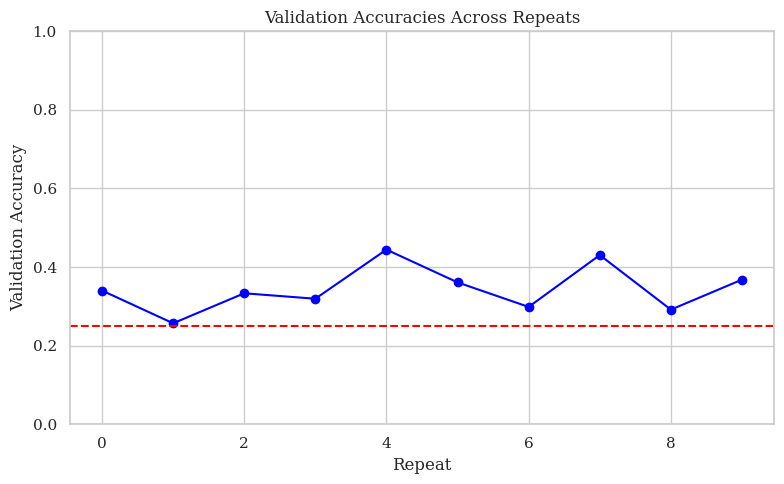

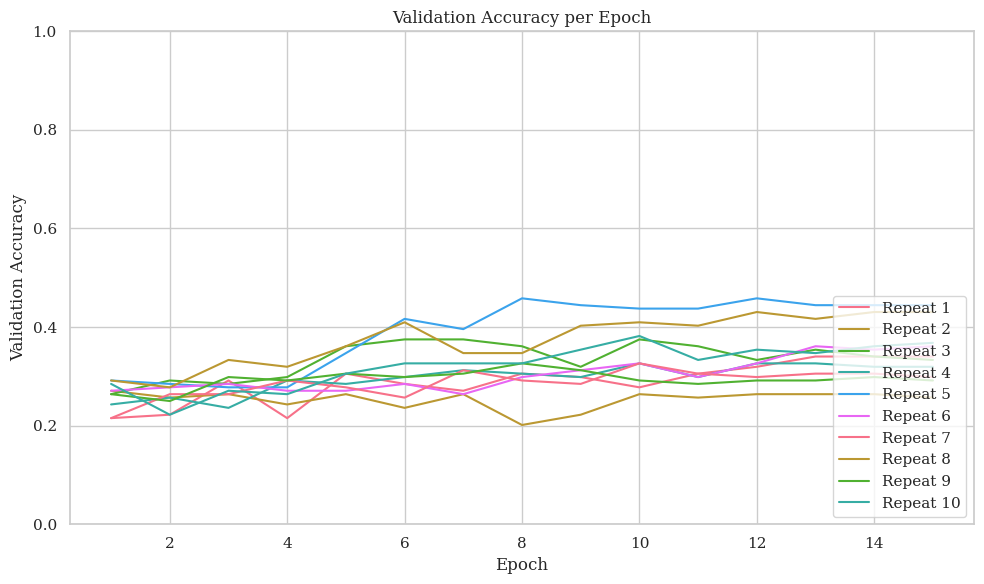

In [37]:
accuracies = results['all_accuracies']
histories = results['all_histories']
epochs = experiment.epochs

# plot validation accuracies across repeats
plt.figure(figsize=(8, 5))
plt.plot(accuracies, marker='o', linestyle='-', color='blue')
plt.axhline(chance_level, color='red', linestyle='--', label='Chance Level (25%)')
plt.title('Validation Accuracies Across Repeats')
plt.xlabel('Repeat')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot validation accuracies over epochs for each repeat
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history[:, 'epoch'], history[:, 'valid_accuracy'], label=f'Repeat {i+1}')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def run_experiments(learning_rate, batch_size, repeats = 10, epochs = 15):
    val_accuracies = []
    epochs_to_best = []
    all_histories = []

    for i in range(repeats):
        print(f"\nRun {i+1}/{repeats}")
        set_random_seeds(seed = 2025 + i, cuda = torch.cuda.is_available())

        data_dir = '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/BCI2000'
        dataset = BCIDataset(data_dir)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])

        X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

        train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
        valid_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

        n_classes = 4
        n_chans = X_train.shape[1]
        input_time_length = X_train.shape[2]
        print(input_time_length)

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length = 'auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion = torch.nn.CrossEntropyLoss,
            optimizer = torch.optim.AdamW,
            optimizer__lr = learning_rate,
            train_split = predefined_split(valid_dataset),
            batch_size = batch_size,
            callbacks = ['accuracy'],
            device = 'cuda' if torch.cuda.is_available() else 'cpu',
            classes = list(range(4))
        )

        clf.fit(train_dataset, y = None, epochs = epochs)

        best_epoch = int(np.argmax(clf.history[:, 'valid_accuracy']))
        best_acc = float(clf.history[best_epoch, 'valid_accuracy'])
        val_accuracies.append(best_acc)
        epochs_to_best.append(best_epoch)
        all_histories.append(clf.history)

    return val_accuracies, epochs_to_best, all_histories


In [30]:
# run training
learning_rate = 0.00075
batch_size = 40

accuracies, epochs_needed, histories = run_experiments(learning_rate, batch_size, repeats = 10)


Run 1/10
Final dataset size: 720 trials, each with shape (64, 640) (channels × timepoints)
Label distribution: [180 180 180 180]
640


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3212        1.8816       0.2500            0.2500        1.6052  2.2786
      2            0.4358        1.5669       0.2292            0.2292        1.4886  2.3382
      3            0.5139        1.4367       0.2708            0.2708        1.4534  2.1498
      4            0.5764        1.4245       0.2500            0.2500        1.4507  2.1476
      5            0.5903        1.3055       0.2778            0.2778        1.4358  2.2181
      6            0.6736        1.2459       0.2917            0.2917        1.4066  2.1520
      7            0.6267        1.1536       0.2569            0.2569        1.4524  2.1633
      8            0.7535        1.1136       0.3750            0.3750        1.3600  2.1971
      9            0.7552        1.0478       0.3194            0.3194

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/3250961820.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_4972/

Final dataset size: 720 trials, each with shape (64, 640) (channels × timepoints)
Label distribution: [180 180 180 180]
640


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3576        1.8613       0.2708            0.2708        1.5616  2.3097
      2            0.4358        1.5742       0.2917            0.2917        1.4759  2.2471
      3            0.5069        1.4731       0.2847            0.2847        1.4802  2.4347
      4            0.5365        1.4031       0.2639            0.2639        1.5044  2.1743
      5            0.5955        1.3111       0.2639            0.2639        1.4990  2.3145
      6            0.6267        1.3067       0.2917            0.2917        1.4723  2.1631
      7            0.6840        1.2036       0.2917            0.2917        1.4999  2.1780
      8            0.6840        1.1911       0.3056            0.3056        1.4695  2.1609
      9            0.7274        1.1515       0.2639            0.2639

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3663        1.8864       0.3056            0.3056        1.5190  2.2967
      2            0.4392        1.5185       0.3194            0.3194        1.4669  2.2659
      3            0.5712        1.4764       0.3333            0.3333        1.3913  2.1964
      4            0.6302        1.3700       0.3056            0.3056        1.3834  2.1577
      5            0.6510        1.2686       0.3125            0.3125        1.4085  2.1615
      6            0.6979        1.2192       0.3333            0.3333        1.3800  2.2934
      7            0.7326        1.1398       0.3472            0.3472        1.4059  2.2720
      8            0.7656        1.0562       0.2986            0.2986        1.4103  2.1572
      9            0.7986        0.9960       0.3750            0.3750

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.2917        1.7948       0.2083            0.2083        1.6852  2.5193
      2            0.4566        1.5549       0.2639            0.2639        1.5149  2.1784
      3            0.5365        1.3979       0.2431            0.2431        1.5097  2.2161
      4            0.6285        1.3008       0.3056            0.3056        1.5093  2.3091
      5            0.7014        1.2620       0.2708            0.2708        1.5153  2.1606
      6            0.7396        1.1191       0.2917            0.2917        1.4755  2.2253
      7            0.7292        1.0722       0.3264            0.3264        1.4981  2.1836
      8            0.7847        0.9801       0.2917            0.2917        1.4863  2.1574
      9            0.8420        0.8931       0.2500            0.2500

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3212        1.8552       0.2569            0.2569        1.5641  2.3424
      2            0.4792        1.5487       0.3056            0.3056        1.4553  2.5138
      3            0.5469        1.4092       0.3472            0.3472        1.3882  2.2204
      4            0.6476        1.3011       0.3472            0.3472        1.3634  2.3287
      5            0.6545        1.1854       0.3819            0.3819        1.3892  2.3771
      6            0.7240        1.1413       0.3750            0.3750        1.3542  2.1872
      7            0.7899        1.0340       0.4375            0.4375        1.2880  2.2473
      8            0.8160        0.8989       0.4653            0.4653        1.2556  2.1751
      9            0.8177        0.8714       0.5069            0.5069

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3542        1.9303       0.2222            0.2222        1.6426  2.3951
      2            0.4896        1.6032       0.2639            0.2639        1.4739  2.1768
      3            0.5417        1.4917       0.2500            0.2500        1.4792  2.1535
      4            0.6007        1.3816       0.2917            0.2917        1.4164  2.1481
      5            0.6319        1.2658       0.3333            0.3333        1.4126  2.2933
      6            0.6927        1.1830       0.3472            0.3472        1.3975  2.2002
      7            0.6997        1.1171       0.3611            0.3611        1.4150  2.1569
      8            0.7396        1.0635       0.3542            0.3542        1.3989  2.1674
      9            0.7934        1.0147       0.3819            0.3819

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3455        1.9307       0.2361            0.2361        1.8141  2.2717
      2            0.4583        1.5149       0.2361            0.2361        1.6140  2.2224
      3            0.5538        1.5109       0.2847            0.2847        1.5662  2.1493
      4            0.5816        1.3565       0.2778            0.2778        1.5799  2.1816
      5            0.6389        1.2857       0.2986            0.2986        1.5163  2.3153
      6            0.6840        1.2648       0.2639            0.2639        1.5464  2.1844
      7            0.7031        1.1269       0.3125            0.3125        1.4772  2.1616
      8            0.7552        1.1217       0.3194            0.3194        1.5265  2.1616
      9            0.7951        0.9953       0.3056            0.3056

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3594        1.8071       0.2014            0.2014        1.5150  2.3684
      2            0.4392        1.6320       0.2917            0.2917        1.4515  2.3128
      3            0.5243        1.5196       0.2917            0.2917        1.4254  2.2706
      4            0.5833        1.3921       0.2986            0.2986        1.4670  2.1764
      5            0.6476        1.2392       0.3403            0.3403        1.4027  2.2756
      6            0.7135        1.1744       0.2917            0.2917        1.4019  2.2100
      7            0.7135        1.0550       0.3125            0.3125        1.4529  2.2427
      8            0.7569        1.0407       0.3333            0.3333        1.4429  2.1797
      9            0.7847        0.9814       0.3681            0.3681

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3646        1.9399       0.2986            0.2986        1.5784  2.2992
      2            0.4219        1.5968       0.2778            0.2778        1.6192  2.2118
      3            0.4670        1.5375       0.3194            0.3194        1.5093  2.1613
      4            0.5330        1.3658       0.3125            0.3125        1.4787  2.1870
      5            0.5764        1.3359       0.2847            0.2847        1.4922  2.2245
      6            0.6094        1.2718       0.2986            0.2986        1.5132  2.2061
      7            0.6233        1.2252       0.2917            0.2917        1.5146  2.1863
      8            0.6701        1.1643       0.2778            0.2778        1.5100  2.1659
      9            0.7361        1.1059       0.3333            0.3333

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3351        1.7943       0.2083            0.2083        1.7101  2.2722
      2            0.4566        1.5655       0.2569            0.2569        1.5376  2.1766
      3            0.5069        1.4621       0.2778            0.2778        1.4998  2.2154
      4            0.5955        1.3634       0.3264            0.3264        1.4591  2.1663
      5            0.6094        1.2916       0.2639            0.2639        1.5217  2.1501
      6            0.6476        1.2007       0.2431            0.2431        1.5458  2.2116
      7            0.6476        1.1223       0.3125            0.3125        1.5067  2.1836
      8            0.6979        1.0385       0.3333            0.3333        1.5000  2.1988
      9            0.7222        1.0953       0.3264            0.3264

In [38]:
# run t-tests
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 5.0436, p: 0.0007


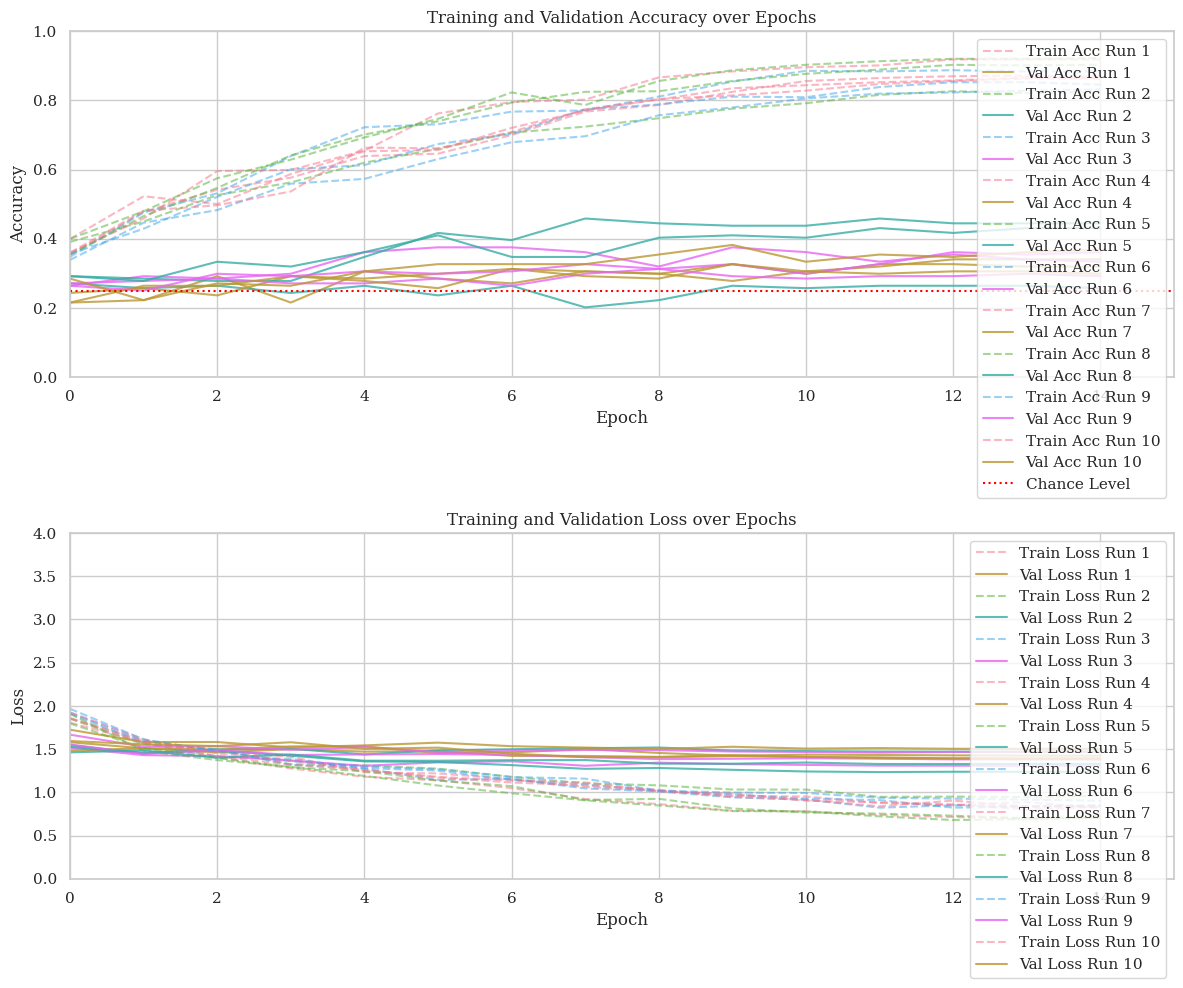

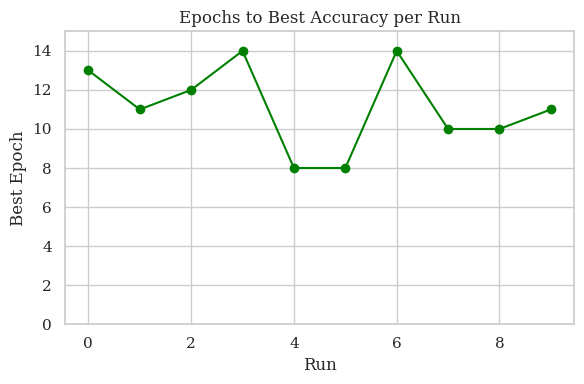

In [39]:
# plot results
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

num_epochs = 15

for i, hist in enumerate(histories):
    axs[0].plot(hist[:, 'train_accuracy'], linestyle='--', alpha=0.5, label=f'Train Acc Run {i + 1}')
    axs[0].plot(hist[:, 'valid_accuracy'], alpha=0.8, label=f'Val Acc Run {i + 1}')
    axs[1].plot(hist[:, 'train_loss'], linestyle='--', alpha=0.5, label=f'Train Loss Run {i + 1}')
    axs[1].plot(hist[:, 'valid_loss'], alpha=0.8, label=f'Val Loss Run {i + 1}')

# plot accuracy per repeat
axs[0].axhline(y=chance_level, color='r', linestyle=':', label='Chance Level')
axs[0].set_title('Training and Validation Accuracy over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, num_epochs)
axs[0].legend()
axs[0].grid(True)

# plot loss per repeat
axs[1].set_title('Training and Validation Loss over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0, 4)
axs[1].set_xlim(0, num_epochs)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# epochs to best accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_needed, marker='o', color='green')
plt.title('Epochs to Best Accuracy per Run')
plt.xlabel('Run')
plt.ylabel('Best Epoch')
plt.ylim(0, num_epochs)
plt.grid(True)
plt.tight_layout()
plt.show()